# Enrichment of the Corpus

* now that we have homogenized, we prepare the corpus i.e. we pre-process more for in-depth analyses 
* for this we:
  * tokenize
  * lemmatize
  * pos-tag
* This can be done with multiple **libraries** (*what concepts are known, do we need the notion of this, I'd say yes!) 
  * spacy
  * stanford-core-nlp
  * nltk
* Pre-Processing is language specific

## 1. Read in the txt data

In [61]:
from pathlib import Path

#### 1.1 Set path to corpus directory 
* Replace ./data/txt/ with path to the data

In [62]:
# or point to standard here?
corpus_dir = Path(r"../data/txt/")

#### 1.2 Read in the files from the directory

In [63]:
from collections import OrderedDict

In [64]:
def read_corpus_linewise(corpus_dir: Path) -> OrderedDict[str,str]:
    corpus = OrderedDict()
    for filepath in corpus_dir.iterdir():
        if filepath.is_file():
            text = filepath.read_text()
            #text = text.replace("\n", " ")
            corpus[filepath.name] = text
    return corpus

In [65]:
corpus = read_corpus_linewise(corpus_dir)

**Prüfen**: Wie viele Dateien wurden eingelesen?

In [66]:
print(len(corpus))

103


#### 1.3 Read in metadata 

In [67]:
import pandas as pd

In [68]:
metadata_dir = Path(r"../data/metadata/")

In [69]:
metadata_filepath =  metadata_dir / Path("MVP-Test-Korpus_Metadata.csv")

In [70]:
metadata_df = pd.read_csv(metadata_filepath, sep=";")

**Prüfen**: Wie sehen unsere Metadaten aus?

In [71]:
metadata_df.head()

,Newspaper,Identifier,Date,Link
0,Vossische Zeitung,SNP27112366,19180101,https://content.staatsbibliothek-berlin.de/zef...
1,Vossische Zeitung,SNP27112366,19180108,https://content.staatsbibliothek-berlin.de/zef...
2,Vossische Zeitung,SNP27112366,19180115,https://content.staatsbibliothek-berlin.de/zef...
3,Vossische Zeitung,SNP27112366,19180122,https://content.staatsbibliothek-berlin.de/zef...
4,Vossische Zeitung,SNP27112366,19180129,https://content.staatsbibliothek-berlin.de/zef...


## 2.Worthäufigkeit mit lazy tokenization

In [72]:
all_texts = " ".join(corpus.values())

In [73]:
words = all_texts.split(" ")

**Prüfen**: Wie sieht die Wortliste aus?

In [74]:
words[50:60]

['Scarpe.',
 'Veiverſeits',
 'von\n;me',
 'und',
 'nördlich',
 'der',
 'Somme',
 'hef-\ntige',
 'Kämpfe.',
 'Die']

Wie viele Wörter gibt es insgesamt?

In [75]:
len(words)

1783703

Welche Wörter kommen wie oft vor? 

In [76]:
from collections import Counter

In [77]:
word_frequencies = Counter(words)

In [80]:
chosen_word = input("Geben Sie ein Wort ein, für welches die Häufigkeit angezeigt wird: ")

Geben Sie ein Wort ein, für welches die Häufigkeit angezeigt wird: Grippe


In [81]:
word_frequencies[chosen_word]

38

## 3. Load NLP Library
* Do we need to install first? Probably not – do we want to show how we would install?

Overview of spacy model available [here](https://spacy.io/models) \

Load language specific model (selection):
* German: 'de_core_news_sm'
* English: 'en_core_news_sm'

### 3.1 Load library

In [37]:
import spacy

In [38]:
! python -m spacy download de_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.5.0/de_core_news_sm-3.5.0-py3-none-any.whl (14.6 MB)

[notice] A new release of pip is available: 23.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [39]:
nlp = spacy.load('de_core_news_sm')

### 3.2 Setting up the pipeline

In [40]:
disable_components = ['ner', 'morphologizer', 'attribute_ruler']

### 3.3 Annotate texts and extract token, lemma, pos

In [86]:
from time import time

In [87]:
took_per_text = []

corpus_annotated = {}
filename_list = list(corpus.keys())
current = time()
for i, doc in enumerate(nlp.pipe(corpus.values(), disable=disable_components)):
    before = current
    current = time()
    took_per_text.append(current - before)
    annotated_text = {}
    annotated_text['Token'] = [tok.text for tok in doc]
    annotated_text['Lemma'] = [tok.lemma_ for tok in doc]
    annotated_text['PoS'] = [tok.tag_ for tok in doc]
    
    sentences = []
    sentence_idx = -1
    for token in doc:
        if token.is_sent_start:
            sentence_idx += 1
        sentences.append(sentence_idx)
    annotated_text['Sentence_idx'] = sentences
    
    corpus_annotated[filename_list[i]] = pd.DataFrame(annotated_text)

#### Wie lange hat das Annotieren gedauert?

In [88]:
import numpy as np

Durschnittlich pro Text in Sekunden:

In [89]:
np.mean(took_per_text)

2.42644638922608

Alle Texte zusammen in Sekunden:

In [90]:
np.sum(took_per_text)

249.92397809028625

**Prüfen**: Länge des annotierten Korpus gleich Länge des Originalkorpus?

In [91]:
len(corpus_annotated)

103

**Prüfen**: Wie sieht die Annotation aus?

In [92]:
corpus_annotated[filename_list[0]].head()

,Token,Lemma,PoS,Sentence_idx
0,Kennmmmmnlie,Kennmmmmnlie,NN,0
1,“,--,$(,0
2,HET,HET,NE,1
3,PU,PU,NE,2
4,"88,4","88,4",NE,3


### 3.4 Worthäufigkeit mit echter Tokenization   

In [93]:
all_words_tokenized = [word for text in corpus_annotated.values() for word in text.Token]

In [94]:
len(all_words_tokenized)

3008370

In [95]:
words_tokenized_frequencies = Counter(all_words_tokenized)

In [96]:
words_tokenized_frequencies[chosen_word]

53

## 4. Metadaten ausweiten

### 4.1 Metadaten sammeln
* Anzahl Lemmata
* Anzahl unique Lemmata
* Anzahl Sätze
* Durschnittliche Satzlänge 

In [97]:
collected_metadata_extension = []
for filename, annotated_text in corpus_annotated.items():
    metadata_extension = {}
    metadata_extension['Filename'] = filename
    metadata_extension['Lemma_Count'] = len(annotated_text) - 1
    metadata_extension['Lemma_Count_Unique'] = len(set(annotated_text.Lemma))
    metadata_extension['Sentence_Count'] = annotated_text.Sentence_idx.iloc[-1]
    metadata_extension['Sentence_Length_Avg'] = annotated_text.groupby('Sentence_idx').Lemma.count().mean()
    collected_metadata_extension.append(metadata_extension)

In [98]:
metadata_to_extend = pd.DataFrame(collected_metadata_extension)

### 4.2 Metadaten hinzufügen

In [99]:
metadata_df

,Newspaper,Identifier,Date,Link
0,Vossische Zeitung,SNP27112366,19180101,https://content.staatsbibliothek-berlin.de/zef...
1,Vossische Zeitung,SNP27112366,19180108,https://content.staatsbibliothek-berlin.de/zef...
2,Vossische Zeitung,SNP27112366,19180115,https://content.staatsbibliothek-berlin.de/zef...
3,Vossische Zeitung,SNP27112366,19180122,https://content.staatsbibliothek-berlin.de/zef...
4,Vossische Zeitung,SNP27112366,19180129,https://content.staatsbibliothek-berlin.de/zef...
...,...,...,...,...
99,Berliner Morgenpost,SNP2719372X,19181203,https://content.staatsbibliothek-berlin.de/zef...
100,Berliner Morgenpost,SNP2719372X,19181210,https://content.staatsbibliothek-berlin.de/zef...
101,Berliner Morgenpost,SNP2719372X,19181217,https://content.staatsbibliothek-berlin.de/zef...
102,Berliner Morgenpost,SNP2719372X,19181224,https://content.staatsbibliothek-berlin.de/zef...


In [57]:
metadata_to_extend

,Filename,Lemma_Count,Lemma_Count_Unique,Sentence_Count,Sentence_Length_Avg
0,SNP2719372X-19180827-0-0-0-0.txt,19127,6784,1407,13.585227
1,SNP27112366-19180604-0-0-0-0.txt,48260,14664,3535,13.648473
2,SNP27112366-19180716-0-0-0-0.txt,42060,12277,3320,12.665161
3,SNP27112366-19180618-0-0-0-0.txt,45297,14035,3068,14.759857
4,SNP27112366-19180101-0-0-0-0.txt,49668,14696,4332,11.462959
...,...,...,...,...,...
74,SNP2719372X-19180716-0-0-0-0.txt,24158,8223,1822,13.252331
75,SNP27112366-19180827-0-0-0-0.txt,37139,11726,2932,12.662803
76,SNP2719372X-19180820-0-0-0-0.txt,20086,7203,1598,12.562226
77,SNP27112366-19180528-0-0-0-0.txt,45784,14624,3203,14.289950


In [103]:
metadata_df['Filename'] = metadata_df['Identifier'] + '-' + metadata_df['Date'].astype(str) + '-0-0-0-0.txt' 

In [104]:
metadata_extendend_df = pd.merge(metadata_df, metadata_to_extend, on="Filename")

## 5. Ergebnisse speichern 

### 5.1 Annotiertes Korpus speichern

In [105]:
result_dir = Path(r"../data/conll")

In [106]:
for filepath, annotated_text in corpus_annotated.items():
    filepath = Path(filepath)
    output_path = result_dir / filepath.with_suffix(".conll")
    annotated_text.to_csv(output_path, sep='\t') # , index=False

### 5.2 Erweiterte Metadaten speichern  

In [ ]:
metadata_extended_filename = Path(r"MVP-Test-Korpus_Metadata-v02.csv")
metadata_extendend_df.to_csv(metadata_dir / metadata_extended_filename, index=False)

In [153]:
annotated_text.shape[0]

38899

In [133]:
list(corpus_annotated.values())[0].columns

Index(['Token', 'Lemma', 'PoS', 'Sentence_idx'], dtype='object')

### Search and plot frequency

In [142]:
import re

In [169]:
class WordSearchEngine():
    
    def __init__(self, corpus_annotated):
        self.search_data = self.prepare_index_dataframe_for_search(corpus_annotated)
    
    def prepare_index_dataframe_for_search(self, corpus_annotated):
        #columns = list(corpus_annotated.values())[0].columns
        #self.full_df = pd.DataFrame(columns = columns)
        for filename, annotated_text in corpus_annotated.items():
            year, month, day = self.get_date_fname(filename)
            annotated_text['month'] = month
        self.full_df = pd.concat(corpus_annotated.values())
        print(f'Searching in a corpus of {self.full_df.shape[0]} word occurences')
        
    def get_date_fname(self, filename):
        date_pattern = re.search(r'(19\d\d)(\d\d)(\d\d)-0-0-0-0', filename)
        year = date_pattern.group(1)
        month = f'{year}-{date_pattern.group(2)}'
        day =  f'{month}-{date_pattern.group(3)}'
        return year, month, day    
        
    def search_and_plot(self):
        search_term = input('Insert a word to search: ')
        result = self.full_df.query(f'Lemma=="{search_term}"')
        
        
        #result = result.groupby('month').count()
        #print(result)
        
        result.groupby('month').count().Lemma.plot();
        

In [170]:
search = WordSearchEngine(corpus_annotated)

Searching in a corpus of 3008370 word occurences


Insert a word to search: Grippe


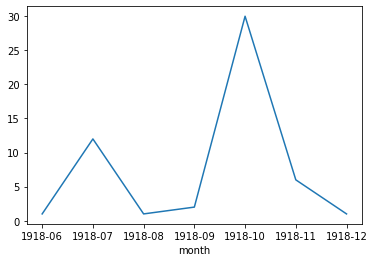

In [171]:
search.search_and_plot()